<a href="https://colab.research.google.com/github/thanit456/NeuroSummary/blob/two/headline_playground_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai
!pip install pythainlp
!pip install emoji
!pip install deepcut

     |████████████████████████████████| 11.1MB 20.1MB/s 
     |████████████████████████████████| 1.4MB 63.2MB/s 
     |████████████████████████████████| 21.7MB 1.2MB/s 
     |████████████████████████████████| 747kB 68.7MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434675 sha256=6201bfee3f6fe718a53840868a86d0bc85626e221d50aa1cf802f3b3cdea58c3
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np


import re

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import copy

from pythainlp.ulmfit import ThaiTokenizer
from pythainlp.corpus.common import thai_stopwords
from pythainlp.util import thai_digit_to_arabic_digit

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:25<00:00, 41350356.38it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 1538054.91it/s]


# Dataframe preparation

In [0]:
df = pd.read_csv('/content/drive/Shared drives/NeuroSummary/data/1_24_thaigov.csv')

df = df.rename(columns={'content': 'raw_content'})
df.head()

,file_name,headline,raw_content,reference
0,24/ด้านเศรษฐกิจ_166.txt,﻿รัฐบาลไทย-ข่าวทำเนียบรัฐบาล-ธอส.ประกาศมาตรการ...,วันจันทร์ที่ 7 มกราคม 2562 ธอส.ประกาศมาตรการบร...,https://www.thaigov.go.th/news/contents/detail...
1,24/ข่าวทำเนียบรัฐบาล_236.txt,﻿รัฐบาลไทย-ข่าวทำเนียบรัฐบาล-สรุปประเด็นนายกรั...,วันเสาร์ที่ 9 กุมภาพันธ์ 2562 สรุปประเด็นนายกร...,https://www.thaigov.go.th/news/contents/detail...
2,24/ด้านความมั่นคง_114.txt,﻿รัฐบาลไทย-ข่าวทำเนียบรัฐบาล-“บิ๊กอู๋”ยื่นสัตย...,วันพฤหัสบดีที่ 31 มกราคม 2562 “บิ๊กอู๋”ยื่นสัต...,https://www.thaigov.go.th/news/contents/detail...
3,24/ด้านเศรษฐกิจ_35.txt,﻿รัฐบาลไทย-ข่าวทำเนียบรัฐบาล-ออมสิน จัดโปรโมชั...,วันศุกร์ที่ 14 ธันวาคม 2561 ออมสิน จัดโปรโมชั่...,https://www.thaigov.go.th/news/contents/detail...
4,24/ด้านการศึกษาฯ_48.txt,﻿รัฐบาลไทย-ข่าวทำเนียบรัฐบาล-ม.มหิดล เตรียมร่ว...,วันจันทร์ที่ 28 มกราคม 2562 ม.มหิดล เตรียมร่วม...,https://www.thaigov.go.th/news/contents/detail...


In [0]:
remove_date(df.iloc[17022]['raw_content'])

'สมอ. เปิดรับฟังความคิดเห็น ผู้มีส่วนได้เสียของร่าง พ.ร.บ. มาตรฐาน สมอ. เปิดรับฟังความคิดเห็น ผู้มีส่วนได้เสียของร่าง พ.ร.บ. มาตรฐาน'

In [0]:
def extract_most_specific_headline(text):
  text = text[text.find('-') + 1:]
  return text[text.find('-') + 1:]

def remove_date(text):
  for _ in range(4):
    text = text[text.find(' ') + 1:]
  return text

def extract_date(text):
  cumulative_idx = 0
  tmp_text = copy.copy(text)
  for _ in range(4):
    idx = tmp_text.find(' ')
    tmp_text = tmp_text[idx + 1:]
    cumulative_idx += (idx + 1)
  return text[: cumulative_idx - 1]

def basic_cleaner(text) :
  special_char = '!|"|#|%|&|\'|,|-|/|:|;|<|=|>|@|_|`|~|\.|\$'.split("|")# type(result)
  nstr = text
  for special in special_char :
    nstr = re.sub(special+"+",special.replace('\\',''),nstr)
  nstr = re.sub("|^||'","",nstr).replace("|","").replace("*","").replace("  "," ").replace(u'\xa0', u' ').replace(u'\u200b', u' ')
  return nstr

def strip_content(text):
  return text.strip()

df['specific_headline'] = df['headline'].apply(extract_most_specific_headline)
df['date'] = df['raw_content'].apply(extract_date)
df['content'] = df['raw_content'].apply(remove_date)
df['content'] = df['content'].apply(basic_cleaner)
df['content'] = df['content'].apply(thai_digit_to_arabic_digit)
df['specific_headline'] = df['specific_headline'].apply(basic_cleaner)
df['specific_headline'] = df['specific_headline'].apply(thai_digit_to_arabic_digit)
df = df.drop('headline', axis=1)
df = df.rename(columns={ 'specific_headline': 'headline'})

# remove redundant sentence
ls = []
for i in range(len(df)):
  text = df.iloc[i]['content'].replace(df.iloc[i]['headline'].strip(), "")
  ls.append(text)
df['content'] = ls
df['content'] = df['content'].apply(strip_content)

In [0]:
df.head()

,file_name,raw_content,reference,headline,date,content
0,24/ด้านเศรษฐกิจ_166.txt,วันจันทร์ที่ 7 มกราคม 2562 ธอส.ประกาศมาตรการบร...,https://www.thaigov.go.th/news/contents/detail...,ธอส.ประกาศมาตรการบรรเทาความเดือดร้อนลูกค้าจากพ...,วันจันทร์ที่ 7 มกราคม 2562,ธนาคารอาคารสงเคราะห์ (ธอส.) ประกาศมาตรการบรรเท...
1,24/ข่าวทำเนียบรัฐบาล_236.txt,วันเสาร์ที่ 9 กุมภาพันธ์ 2562 สรุปประเด็นนายกร...,https://www.thaigov.go.th/news/contents/detail...,สรุปประเด็นนายกรัฐมนตรีกล่าวในรายการศาสตร์พระร...,วันเสาร์ที่ 9 กุมภาพันธ์ 2562,พลเอก ประยุทธ์ จันทร์โอชา นายกรัฐมนตรีได้กล่าว...
2,24/ด้านความมั่นคง_114.txt,วันพฤหัสบดีที่ 31 มกราคม 2562 “บิ๊กอู๋”ยื่นสัต...,https://www.thaigov.go.th/news/contents/detail...,“บิ๊กอู๋”ยื่นสัตยาบัน C188 ต่อ ILO แสดงเจตนารม...,วันพฤหัสบดีที่ 31 มกราคม 2562,รมว.แรงงาน ยื่นสัตยาบันอนุสัญญา ILO ฉบับที่ 18...
3,24/ด้านเศรษฐกิจ_35.txt,วันศุกร์ที่ 14 ธันวาคม 2561 ออมสิน จัดโปรโมชั่...,https://www.thaigov.go.th/news/contents/detail...,ออมสิน จัดโปรโมชั่นพิเศษ Thailand Smart Money ...,วันศุกร์ที่ 14 ธันวาคม 2561,ออมสินจัดโปรพิเศษ Thailand Smart Money กรุงเทพ...
4,24/ด้านการศึกษาฯ_48.txt,วันจันทร์ที่ 28 มกราคม 2562 ม.มหิดล เตรียมร่วม...,https://www.thaigov.go.th/news/contents/detail...,ม.มหิดล เตรียมร่วมมือกับ ม.บูรพา ผลิตพัฒนากำลั...,วันจันทร์ที่ 28 มกราคม 2562,ศ.คลินิก นพ.อุดม คชินทร รมช.ศธ. ประชุมหารือกับ...


In [0]:
df.iloc[-3]['headline']

'นายกรัฐมนตรีย้ำรัฐบาลมุ่งพัฒนาโครงสร้างพื้นฐานเพื่อกระจายความเจริญไปสู่ชนบลให้ได้ในอนาคต'

In [0]:
df.iloc[-3]['content']

'วันนี้ (22 สิงหาคม 2559) เวลา 14.00 น. ณ บริเวณห้องโถง ชั้น 1 ตึกบัญชาการ 1 ทำเนียบรัฐบาล ภายหลังการประชุมคณะรัฐมนตรี พลเอกประยุทธ์ จันทร์โอชา นายกรัฐมนตรี ได้กล่าวถึงเรื่อง แผนการดำเนินงานของรัฐบาลที่ผ่านมาว่า รัฐบาลได้มุ่งเน้นการพัฒนาโครงสร้างพื้นฐาน เชื่อมโยงสังคมเมืองไปสู่สังคมชนบท พร้อมทั้งสร้างรายได้ให้กระจายไปสู่พื้นที่ชนบทให้ได้ในอนาคต แต่ทั้งนี้ การดำเนินการดังกล่าว อาจจะต้องใช้ระยะเวลา เพื่อแก้ปัญหาและพัฒนาประเทศไปสู่ความมั่นคง มั่งคั่ง อย่างยั่งยืน พร้อมกล่าวย้ำว่า วันนี้รัฐบาลได้ทำงานกันอย่างมุ่งมั่น เพื่อแก้ไขปัญหาที่มีมาอย่างยาวนานให้สำเร็จ โดยคณะรัฐมนตรีและคณะรักษาความสงบแห่งชาติได้ร่วมกันหารือเพื่อวางแนวทางในการดำเนินการ ปรับปรุงโครงสร้างทั้งหมดอย่างเต็มกำลังและเร่งด่วน ขณะเดียวกัน นายกรัฐมนตรีได้เชิญชวนประชาชนทุกคนร่วมกันทำกิจกรรมการปลูกป่าในเชิงวิชาการเพื่อเพิ่มพื้นที่ธรรมชาติที่สมบูรณ์ให้กับประเทศต่อไป - กลุ่มยุทธศาสตร์และแผนการประชาสัมพันธ์ สำนักโฆษก'

In [0]:
# df = df.drop('removed_stopwords_content', axis=1)
# df = df.drop('specific_headline', axis=1)

# df['content'] = tokenized_ls
# df.to_pickle('/content/drive/Shared drives/NeuroSummary/data/cleaned_thaigov_tokenized.pkl')

# df.head()


In [0]:
# df = df.drop('removed_stopword_content', axis=1)

In [0]:
from pythainlp.tokenize import word_tokenize

# ulmfitTokenizer = ThaiTokenizer()

def preprocessed(df, column='content'):
  tokenized_ls = []
  for text in tqdm_notebook(df[column]):
    tokenized_text = word_tokenize(text, engine='deepcut')
    tokenized_ls.append(tokenized_text)
  return tokenized_ls

tokenized_content_ls = preprocessed(df)
tokenized_headline_ls = preprocessed(df, column='headline')

df['tokenized_deepcut_content'] = tokenized_content_ls
df['tokenized_deepcut_headline'] = tokenized_headline_ls

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [0]:
df.head()

,file_name,raw_content,reference,headline,date,content,tokenized_deepcut_content,tokenized_deepcut_headline
0,24/ด้านเศรษฐกิจ_166.txt,วันจันทร์ที่ 7 มกราคม 2562 ธอส.ประกาศมาตรการบร...,https://www.thaigov.go.th/news/contents/detail...,ธอส.ประกาศมาตรการบรรเทาความเดือดร้อนลูกค้าจากพ...,วันจันทร์ที่ 7 มกราคม 2562,ธนาคารอาคารสงเคราะห์ (ธอส.) ประกาศมาตรการบรรเท...,"[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, ความ, เดือดร้อ..."
1,24/ข่าวทำเนียบรัฐบาล_236.txt,วันเสาร์ที่ 9 กุมภาพันธ์ 2562 สรุปประเด็นนายกร...,https://www.thaigov.go.th/news/contents/detail...,สรุปประเด็นนายกรัฐมนตรีกล่าวในรายการศาสตร์พระร...,วันเสาร์ที่ 9 กุมภาพันธ์ 2562,พลเอก ประยุทธ์ จันทร์โอชา นายกรัฐมนตรีได้กล่าว...,"[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, กล่าว, ใน, ราย..."
2,24/ด้านความมั่นคง_114.txt,วันพฤหัสบดีที่ 31 มกราคม 2562 “บิ๊กอู๋”ยื่นสัต...,https://www.thaigov.go.th/news/contents/detail...,“บิ๊กอู๋”ยื่นสัตยาบัน C188 ต่อ ILO แสดงเจตนารม...,วันพฤหัสบดีที่ 31 มกราคม 2562,รมว.แรงงาน ยื่นสัตยาบันอนุสัญญา ILO ฉบับที่ 18...,"[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ..."
3,24/ด้านเศรษฐกิจ_35.txt,วันศุกร์ที่ 14 ธันวาคม 2561 ออมสิน จัดโปรโมชั่...,https://www.thaigov.go.th/news/contents/detail...,ออมสิน จัดโปรโมชั่นพิเศษ Thailand Smart Money ...,วันศุกร์ที่ 14 ธันวาคม 2561,ออมสินจัดโปรพิเศษ Thailand Smart Money กรุงเทพ...,"[ออมสิน, จัด, โปรพิเศษ, , Thailand, , Smart,...","[ออมสิน, , จัด, โปรโมชั่น, พิเศษ, , Thailand..."
4,24/ด้านการศึกษาฯ_48.txt,วันจันทร์ที่ 28 มกราคม 2562 ม.มหิดล เตรียมร่วม...,https://www.thaigov.go.th/news/contents/detail...,ม.มหิดล เตรียมร่วมมือกับ ม.บูรพา ผลิตพัฒนากำลั...,วันจันทร์ที่ 28 มกราคม 2562,ศ.คลินิก นพ.อุดม คชินทร รมช.ศธ. ประชุมหารือกับ...,"[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, ร่วมมือ, กับ, , ม.บูรพ..."


In [0]:
# remove stopwords
def remove_stopwords(tokenized_ls):
  removed_stopwords = []
  for text in tqdm_notebook(tokenized_ls):
    tmp = []
    for word in text:
      if word not in thai_stopwords():
        tmp.append(word)
    removed_stopwords.append(tmp)
  return removed_stopwords

removed_stopwords_contents = remove_stopwords(tokenized_content_ls)
removed_stopwords_headlines = remove_stopwords(tokenized_headline_ls)
df['removed_stopwords_content'] = removed_stopwords_contents
df['removed_stopwords_headline'] = removed_stopwords_headlines

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df.head()

,file_name,raw_content,reference,headline,date,content,tokenized_deepcut_content,tokenized_deepcut_headline,removed_stopwords_content,removed_stopwords_headline
0,24/ด้านเศรษฐกิจ_166.txt,วันจันทร์ที่ 7 มกราคม 2562 ธอส.ประกาศมาตรการบร...,https://www.thaigov.go.th/news/contents/detail...,ธอส.ประกาศมาตรการบรรเทาความเดือดร้อนลูกค้าจากพ...,วันจันทร์ที่ 7 มกราคม 2562,ธนาคารอาคารสงเคราะห์ (ธอส.) ประกาศมาตรการบรรเท...,"[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, ความ, เดือดร้อ...","[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, เดือดร้อน, ลูก..."
1,24/ข่าวทำเนียบรัฐบาล_236.txt,วันเสาร์ที่ 9 กุมภาพันธ์ 2562 สรุปประเด็นนายกร...,https://www.thaigov.go.th/news/contents/detail...,สรุปประเด็นนายกรัฐมนตรีกล่าวในรายการศาสตร์พระร...,วันเสาร์ที่ 9 กุมภาพันธ์ 2562,พลเอก ประยุทธ์ จันทร์โอชา นายกรัฐมนตรีได้กล่าว...,"[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, กล่าว, ใน, ราย...","[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, รายการศาสตร์, ..."
2,24/ด้านความมั่นคง_114.txt,วันพฤหัสบดีที่ 31 มกราคม 2562 “บิ๊กอู๋”ยื่นสัต...,https://www.thaigov.go.th/news/contents/detail...,“บิ๊กอู๋”ยื่นสัตยาบัน C188 ต่อ ILO แสดงเจตนารม...,วันพฤหัสบดีที่ 31 มกราคม 2562,รมว.แรงงาน ยื่นสัตยาบันอนุสัญญา ILO ฉบับที่ 18...,"[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ...","[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ..."
3,24/ด้านเศรษฐกิจ_35.txt,วันศุกร์ที่ 14 ธันวาคม 2561 ออมสิน จัดโปรโมชั่...,https://www.thaigov.go.th/news/contents/detail...,ออมสิน จัดโปรโมชั่นพิเศษ Thailand Smart Money ...,วันศุกร์ที่ 14 ธันวาคม 2561,ออมสินจัดโปรพิเศษ Thailand Smart Money กรุงเทพ...,"[ออมสิน, จัด, โปรพิเศษ, , Thailand, , Smart,...","[ออมสิน, , จัด, โปรโมชั่น, พิเศษ, , Thailand...","[ออมสิน, โปรพิเศษ, , Thailand, , Smart, , M...","[ออมสิน, , โปรโมชั่น, พิเศษ, , Thailand, , ..."
4,24/ด้านการศึกษาฯ_48.txt,วันจันทร์ที่ 28 มกราคม 2562 ม.มหิดล เตรียมร่วม...,https://www.thaigov.go.th/news/contents/detail...,ม.มหิดล เตรียมร่วมมือกับ ม.บูรพา ผลิตพัฒนากำลั...,วันจันทร์ที่ 28 มกราคม 2562,ศ.คลินิก นพ.อุดม คชินทร รมช.ศธ. ประชุมหารือกับ...,"[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, ร่วมมือ, กับ, , ม.บูรพ...","[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, , ม.บูรพา ผลิต, พัฒนา,..."


In [0]:
# seperate class_name from file_name
ls = []
for file_name in df['file_name']:
  class_name = file_name[file_name.find('/') + 1: file_name.find('_')]
  ls.append(class_name)
df['class_name'] = ls

In [0]:
df.head()

,file_name,raw_content,reference,headline,date,content,tokenized_deepcut_content,tokenized_deepcut_headline,removed_stopwords_content,removed_stopwords_headline,class_name
0,24/ด้านเศรษฐกิจ_166.txt,วันจันทร์ที่ 7 มกราคม 2562 ธอส.ประกาศมาตรการบร...,https://www.thaigov.go.th/news/contents/detail...,ธอส.ประกาศมาตรการบรรเทาความเดือดร้อนลูกค้าจากพ...,วันจันทร์ที่ 7 มกราคม 2562,ธนาคารอาคารสงเคราะห์ (ธอส.) ประกาศมาตรการบรรเท...,"[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, ความ, เดือดร้อ...","[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, เดือดร้อน, ลูก...",ด้านเศรษฐกิจ
1,24/ข่าวทำเนียบรัฐบาล_236.txt,วันเสาร์ที่ 9 กุมภาพันธ์ 2562 สรุปประเด็นนายกร...,https://www.thaigov.go.th/news/contents/detail...,สรุปประเด็นนายกรัฐมนตรีกล่าวในรายการศาสตร์พระร...,วันเสาร์ที่ 9 กุมภาพันธ์ 2562,พลเอก ประยุทธ์ จันทร์โอชา นายกรัฐมนตรีได้กล่าว...,"[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, กล่าว, ใน, ราย...","[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, รายการศาสตร์, ...",ข่าวทำเนียบรัฐบาล
2,24/ด้านความมั่นคง_114.txt,วันพฤหัสบดีที่ 31 มกราคม 2562 “บิ๊กอู๋”ยื่นสัต...,https://www.thaigov.go.th/news/contents/detail...,“บิ๊กอู๋”ยื่นสัตยาบัน C188 ต่อ ILO แสดงเจตนารม...,วันพฤหัสบดีที่ 31 มกราคม 2562,รมว.แรงงาน ยื่นสัตยาบันอนุสัญญา ILO ฉบับที่ 18...,"[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ...","[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ...",ด้านความมั่นคง
3,24/ด้านเศรษฐกิจ_35.txt,วันศุกร์ที่ 14 ธันวาคม 2561 ออมสิน จัดโปรโมชั่...,https://www.thaigov.go.th/news/contents/detail...,ออมสิน จัดโปรโมชั่นพิเศษ Thailand Smart Money ...,วันศุกร์ที่ 14 ธันวาคม 2561,ออมสินจัดโปรพิเศษ Thailand Smart Money กรุงเทพ...,"[ออมสิน, จัด, โปรพิเศษ, , Thailand, , Smart,...","[ออมสิน, , จัด, โปรโมชั่น, พิเศษ, , Thailand...","[ออมสิน, โปรพิเศษ, , Thailand, , Smart, , M...","[ออมสิน, , โปรโมชั่น, พิเศษ, , Thailand, , ...",ด้านเศรษฐกิจ
4,24/ด้านการศึกษาฯ_48.txt,วันจันทร์ที่ 28 มกราคม 2562 ม.มหิดล เตรียมร่วม...,https://www.thaigov.go.th/news/contents/detail...,ม.มหิดล เตรียมร่วมมือกับ ม.บูรพา ผลิตพัฒนากำลั...,วันจันทร์ที่ 28 มกราคม 2562,ศ.คลินิก นพ.อุดม คชินทร รมช.ศธ. ประชุมหารือกับ...,"[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, ร่วมมือ, กับ, , ม.บูรพ...","[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, , ม.บูรพา ผลิต, พัฒนา,...",ด้านการศึกษาฯ


In [0]:
df.to_pickle('/content/drive/Shared drives/NeuroSummary/data/all_deepcut_thaigov_1_24.pkl')

In [0]:
# !git clone 
# !python 

In [0]:
# # tokenize sentence
# from pythainlp.tokenize import sent_tokenize

# def sent_preprocessed(df, column='content'):
#   tokenized_ls = []
#   for text in tqdm_notebook(df[column]):
#     tokenized_text = sent_tokenize(text, engine='crfcut')
#     tokenized_ls.append(tokenized_text)
#   return tokenized_ls

# sent_tokenized_content_ls = sent_preprocessed(df)
# sent_tokenized_headline_ls = sent_preprocessed(df, column='headline')
# df['tokenized_crfcut_content'] = sent_tokenized_content_ls
# df['tokenized_crfcut_headline'] = sent_tokenized_headline_ls

# Splitting dataset

In [0]:
old_df = pd.read_pickle('/content/drive/Shared drives/NeuroSummary/data/all_deepcut_thaigov_1_24.pkl')

df = pd.DataFrame({'content': old_df['removed_stopwords_content'], 'headline': old_df['removed_stopwords_headline']})

train_df, val_test_df = train_test_split(df, test_size=0.33, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)

In [0]:
df.head()

,content,headline
0,"[ธนาคารอาคารสงเคราะห์, , (, ธอส., ), , ประกา...","[ธอส., ประกาศ, มาตรการ, บรรเทา, เดือดร้อน, ลูก..."
1,"[พลเอก ประยุทธ์ จันทร์โอชา, , นายก, รัฐมนตรี,...","[สรุป, ประเด็น, นายก, รัฐมนตรี, รายการศาสตร์, ..."
2,"[รมว., แรงงาน, , ยื่น, สัตยาบัน, อนุสัญญา, ,...","[“, บิ๊กอู๋, ”, ยื่น, สัตยาบัน, , C, 188, , ..."
3,"[ออมสิน, โปรพิเศษ, , Thailand, , Smart, , M...","[ออมสิน, , โปรโมชั่น, พิเศษ, , Thailand, , ..."
4,"[ศ.คลินิก, นพ.อุดม คชินทร, , รมช., ศธ., , ป...","[ม., มหิดล, , เตรียม, , ม.บูรพา ผลิต, พัฒนา,..."


In [0]:
import pickle
THAIGOV_PATH = '/content/drive/My Drive/NLP/thaigov_headline_prediction/'
with open(THAIGOV_PATH + 'train.pkl', 'wb') as f:
  pickle.dump(train_df, f)

with open(THAIGOV_PATH + 'val.pkl', 'wb') as f:
  pickle.dump(val_df, f)

with open(THAIGOV_PATH + 'test.pkl', 'wb') as f:
  pickle.dump(test_df, f)

# filename2meta preparation

In [0]:
# filename2meta_df = pd.read_pickle('/content/drive/Shared drives/NeuroSummary/data/cmu_papers/filename2meta.pickle')
# filename2meta_df.head()
with open('/content/drive/Shared drives/NeuroSummary/data/cmu_papers/filename2meta.pickle', 'rb') as f:
  filename2meta = pickle.load(f)

file_names = filename2meta.keys() 
abs_file_names = dict()
for file_name in file_names:
  if '_abs.pdf' in file_name:
    if filename2meta[file_name]['is_thai']:
      abs_file_names[file_name ] = filename2meta[file_name]['title_th']
  
print('#abs :', len(abs_file_names))

with open('/content/drive/Shared drives/NeuroSummary/data/cmu_papers/abstract2headline_th.pickle', 'wb') as f:
  pickle.dump(abs_file_names, f)

#abs : 333


# EDA

##### TRAIN ######


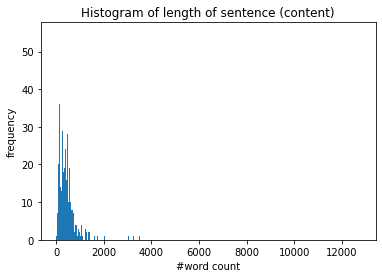

Max length (content) :12779


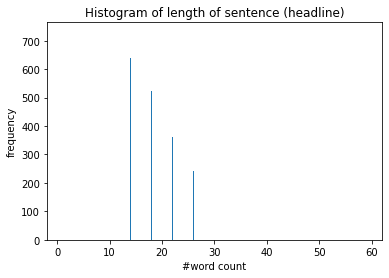

Max length (headline) :59
##### VALIDATION ######


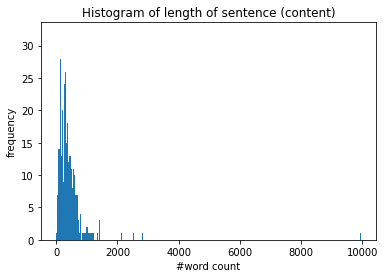

Max length (content) :9945


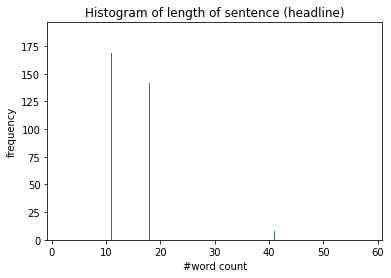

Max length (headline) :58
##### TEST ######


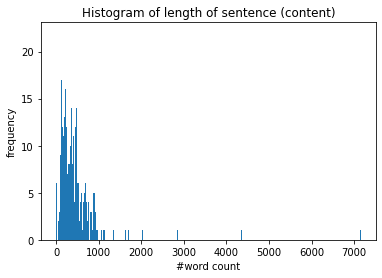

Max length (content) :7151


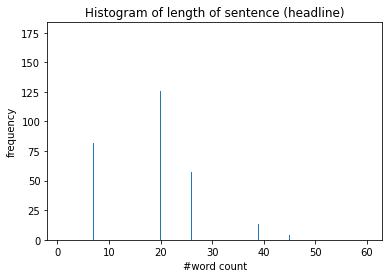

Max length (headline) :60


In [0]:
def show_statistics(dataset, title='content'):
  length = [len(data) for data in dataset]
 
  plt.hist(length, bins=len(length))
  plt.title('Histogram of length of sentence (' + title + ')')
  plt.xlabel('#word count')
  plt.ylabel('frequency')
  plt.show()

  maxlen = max(length)
  print('Max length (' + title + ') :' + str(maxlen))
  return maxlen

print('##### TRAIN ######')  
train_content_maxlen = show_statistics(train_df['content'])
train_headline_maxlen = show_statistics(train_df['headline'], title='headline')

print('##### VALIDATION ######')  
val_content_maxlen = show_statistics(val_df['content'])
val_headline_maxlen = show_statistics(val_df['headline'], title='headline')

print('##### TEST ######')  
test_content_maxlen = show_statistics(test_df['content'])
test_headline_maxlen = show_statistics(test_df['headline'], title='headline')

# load prepared data

In [0]:
import pickle 

THAIGOV_PATH = '/content/drive/My Drive/NLP/thaigov_headline_prediction/'

with open(THAIGOV_PATH + 'train.pkl', 'rb') as f:
  train_set = pickle.load(f)

with open(THAIGOV_PATH + 'val.pkl', 'rb') as f:
  val_set = pickle.load(f)

with open(THAIGOV_PATH + 'test.pkl', 'rb') as f:
  test_set = pickle.load(f)


# Document to vector (Pythainlp)

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import * 

# data_path = 'th-all'
# model_path ='thwiki_data'
model_path = ''

In [0]:
_THWIKI_LSTM

{'itos_fname': '/root/pythainlp-data/itos_lstm.pkl',
 'wgts_fname': '/root/pythainlp-data/thwiki_model_lstm.pth'}

In [0]:
#configuration
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

data_lm = (TextList.from_df(train_set, model_path, cols=['content'], processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=64))
data_lm.sanity_check()
data_lm.save('thaigov_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [0]:
data_lm = load_data(model_path,'thaigov_lm.pkl') #Target task data
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(11519, 116)

In [0]:
data_lm.show_batch(5)

idx,text
0,การ ดูแล เพื่อ ใน ช่วง เปลี่ยน ผ่าน จะ สามารถ ดูแล ได้ กรณี ประชาชน ขอให้ เปิดเผย รายชื่อ สนช . จำนวน 142 คน ที่ ผ่าน การพิจารณา ให้ ความ เห็นชอบ ร่าง พรบ. โรงงาน นั้น นายกรัฐมนตรี กล่าวว่า ข้อเสนอ ดังกล่าว เป็นการ เรียกร้อง ที่ ไม่ ถูกต้อง เพราะ การพิจารณา ดังกล่าว เป็น การทำงาน ของ
1,ซึ่งกันและกัน และ ไม่ ไป ละเมิด สิทธิ ผู้อื่น โดย คำนึงถึง หลัก ปฏิญญาสากลว่าด้วยสิทธิมนุษยชน ( universal xxunk of human rights ) ที่ผ่านมา รัฐบาล ไม่ได้ ละเลย ต่อ การ ดำเนินงาน ด้าน สิทธิมนุษยชน จะ เห็น ได้ จาก การ ประกาศ ใช้ รัฐธรรมนูญ แห่ง ราชอาณาจักร ไทย พุทธศักราช 2560 นโยบาย ลด ความเหลื่อมล้ำ ใน
2,7 กลุ่ม สาขา อาชีพ ประกอบด้วย ( 1 ) กลุ่ม สาขา อาชีพ ด้าน โลจิสติกส์ โครงสร้างพื้นฐาน ( 2 ) กลุ่ม สาขา อาชีพ โลจิสติกส์ บริการ ( 3 ) กลุ่ม สาขา อาชีพ หุ่นยนต์ และ ระบบ อัตโนมัติ ( 4 ) กลุ่ม สาขา อาชีพ ดิจิทัล ( 5 ) กลุ่ม สาขา อาชีพ อาหาร
3,ต่อ สังคม ของ ผู้ประกอบการ อุตสาหกรรม แร่ ปี 61 ปลัด พสุ ฯ เปิดงาน “ 1 ทศวรรษ csr-dpim สู่ การ สร้างสรรค์ สังคม ” และ มอบ รางวัล ให้ แก่ สถานประกอบการ ที่ ผ่าน เกณฑ์ มาตรฐาน ความรับผิดชอบ ต่อ สังคม ของ ผู้ประกอบการ อุตสาหกรรม แร่ ปี 61 เมื่อ วันที่
4,"ตลอด ทั้งวัน ตั้ง แต่เช้า จน จนถึง ช่วง เย็น จำนวน กว่า วัน ละ 15,000 คน โดยเฉพาะ ใน วันหยุด เสาร์ - อาทิตย์ ก็ จะ มี นักท่องเที่ยว มา เที่ยว ชม เพิ่มขึ้น กว่า แต่ก่อน ซึ่ง คาด ว่า จะ เพิ่มขึ้น เรื่อยๆ ส่งผล ให้ บรรยากาศ ที่ วัด ไชย วัฒนา ราม ตลอด ทั้งวัน เต็มไปด้วย นักท่องเที่ยว ส่วนใหญ่ มา ตามรอย ละคร"


In [0]:
#configuration
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args) #for step 2

# load pretrained models ( Step 1. The LM is trained on a general-domain corpus to capture
# general features of the language in different layers)
learn.load_pretrained(**_THWIKI_LSTM) 

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (11519 items)
x: LMTextList
xxbos   นายกรัฐมนตรี มอบหมาย ให้ กระทรวงอุตสาหกรรม ชี้แจง ข้อ เท็จ   พรบ. โรงงาน   ระบุ ไม่ต้องการ ให้ ใคร เดือดร้อน   นายกรัฐมนตรี มอบหมาย ให้ กระทรวงอุตสาหกรรม ชี้แจง ข้อ เท็จ   พรบ. โรงงาน   ระบุ ไม่ต้องการ ให้ ใคร เดือดร้อน   วันนี้   ( 26   กุมภาพันธ์   2562 )   เวลา   13.20   น.   ณ   บริเวณ ห้องโถง ตึก บัญชาการ   1   ทำเนียบรัฐบาล   พลเอก   ประยุทธ์   จันทร์ โอชา   นายกรัฐมนตรี กล่าว ภายหลัง การประชุม คณะรัฐมนตรี กรณี สภานิติบัญญัติ แห่งชาติ   (   สนช .)   มีมติ เห็นชอบ ให้ ประกาศใช้ ร่างพระราชบัญญัติ   ( พ.ร.บ. )   โรงงาน ว่า   ได้ มอบหมาย ให้ กระทรวงอุตสาหกรรม ชี้แจง ข้อเท็จจริง ประเด็น ดัง กล่าวว่า มีความสำคัญ อย่างไร   และ ไม่ต้องการ ให้ ใคร เดือดร้อน   ซึ่ง กฎหมาย ทุก ฉบับ ต้อง มี ทางออก   ทุกคน ต้อง มี การ ปรับ เปลี่ยนไป บ้าง   หาก เดือดร้อน   จะ ต้องหา มาตรการ ที่ เหมาะสม ใน การ ดูแล   เพื่อ ใน ช่วง เปลี่ยน ผ่าน จะ สามารถ ดูแล ได้   กรณี ประชาชน ขอให้ เปิดเผย รายชื่อ   สนช .   จำนวน   142 

In [0]:
#train frozen
print('training frozen')
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,3.751613,3.545382,0.369879,09:43


In [0]:
#train unfrozen (take about 5 mins)
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,3.584172,3.471612,0.377547,09:55
1,3.507016,3.354032,0.391242,09:55
2,3.394926,3.250204,0.404215,09:56
3,3.366464,3.178041,0.413104,09:56
4,3.282397,3.128906,0.419485,09:57
5,3.177837,3.096390,0.423372,09:57


Streaming output truncated to the last 5000 lines.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf T

Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save_encoder('thaigov_enc')

In [0]:
learn.save(THAIGOV_PATH + 'learn_thaigov_lm')

# Tf-idf, Topic modeling and UMAP

In [0]:
print('num classes : ', len(old_df['class_name'].unique()))

num classes :  22


In [0]:
# De-tokenization
contents = []
headlines = []

for ls in tqdm_notebook(train_set['content']):
  contents.append(''.join(ls))

for ls in tqdm_notebook(train_set['headline']):
  contents.append(''.join(ls))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pythainlp.corpus.common import thai_stopwords

vectorizer = TfidfVectorizer(stop_words=thai_stopwords(), 
                             max_features=10000, 
                             max_df=0.5,
                             use_idf=True,
                             ngram_range=(1, 3))
X = vectorizer.fit_transform(contents)
print('Shape : ', X.shape)

term = vectorizer.get_feature_names()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กคน', 'กคร', 'กครา', 'กคราว', 'กจะ', 'กช', 'กต', 'กท', 'กทาง', 'กน', 'กระท', 'กระน', 'กระไร', 'กล', 'กว', 'กส', 'กหน', 'กอ', 'กอย', 'กำล', 'กเม', 'กแห', 'กๆ', 'ขณะท', 'ขณะน', 'ขณะหน', 'ขณะเด', 'คงอย', 'คร', 'ครบคร', 'ครบถ', 'คราท', 'คราน', 'คราวก', 'คราวท', 'คราวน', 'คราวหน', 'คราวหล', 'คราวโน', 'คราหน', 'คล', 'งก', 'งกระน', 'งกล', 'งกว', 'งข', 'งคง', 'งคน', 'งครา', 'งคราว', 'งง', 'งจ', 'งจน', 'งจะ', 'งจาก', 'งต', 'งท', 'งน', 'งบ', 'งปวง', 'งมวล', 'งละ', 'งว', 'งส', 'งหน', 'งหมด', 'งหมาย', 'งหล', 'งหลาย', 'งอย', 'งเก', 'งเคย', 'งเน', 'งเป', 'งเม', 'งแก', 'งแต', 'งแม', 'งแล', 'งโง', 'งโน', 'งใด', 'งใหญ', 'งไง', 'งได', 'งไหน', 'งๆ', 'งๆจ', 'จก', 'จจ', 'จนกระท', 'จนกว', 'จนขณะน', 'จนถ', 'จนท', 'จนบ', 'จนเม', 'จนแม', 'จร', 'จรดก', 'จวนเจ', 'จวบก', 'จส', 'จสมบ', 'จะได', 'จากน', 'จำเป', 'จแล', 'ฉะ

Shape :  (23270, 10000)


In [0]:
# clustering text with k-means
from sklearn.cluster import KMeans

num_clusters = 22

km = KMeans(n_clusters=num_clusters, verbose=1)
km.fit(X)

clusters = km.labels_.tolist()

Initialization complete
Iteration  0, inertia 39986.040
Iteration  1, inertia 21715.100
Iteration  2, inertia 21468.936
Iteration  3, inertia 21349.490
Iteration  4, inertia 21286.971
Iteration  5, inertia 21262.774
Iteration  6, inertia 21247.962
Iteration  7, inertia 21238.383
Iteration  8, inertia 21232.388
Iteration  9, inertia 21226.004
Iteration 10, inertia 21219.082
Iteration 11, inertia 21213.337
Iteration 12, inertia 21206.427
Iteration 13, inertia 21203.200
Iteration 14, inertia 21202.676
Iteration 15, inertia 21202.386
Iteration 16, inertia 21201.996
Iteration 17, inertia 21201.370
Iteration 18, inertia 21201.104
Iteration 19, inertia 21200.982
Iteration 20, inertia 21200.868
Iteration 21, inertia 21200.795
Iteration 22, inertia 21200.662
Iteration 23, inertia 21200.398
Iteration 24, inertia 21199.614
Iteration 25, inertia 21198.282
Iteration 26, inertia 21197.185
Iteration 27, inertia 21196.959
Iteration 28, inertia 21196.883
Iteration 29, inertia 21196.804
Iteration 30, in

KeyboardInterrupt: ignored

In [0]:
# applying LSA for topic modelling
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X, n_components=22, n_iter=100, random_state=42, verbose=1)

for i, comp in tqdm_notebook(enumerate(VT)):
  terms_comp = zip(terms, comp)
  sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[7:]
  print("Concept " + str(i) + ": ")
  for t in sorted_items:
    print(t[0])
  print(" ")

In [0]:
!pip install umap

In [0]:
import umap 
X_topics = U*Sigma
embedding  = umap.UMAP(n_neighbours=100, min_dist=0.5, random_state=42).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],
            c=clusters,
            s=22,
            edgecolor='none')
plt.show()

Pretrained word2vec
===

In [0]:
from pythainlp import word_vector
import_embedding = word_vector.get_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
## ! use only 200 first words for headline generation
def use_firt_n_words(df_content, n):
  new_ls = []
  for content in df_content:
    new_ls.append(content[:n])
  return new_ls

words_200_train_contents = use_firt_n_words(train_set['content'], n=200)
words_50_train_headlines = use_firt_n_words(train_set['headline'], n=50)

In [0]:
import collections
def create_index(input_data,threshold):
    input_text = [data for data in input_data]
    # counts of word type has to be above or equal threshold
    words = [word for sublist in input_text for word in sublist]
    print("words :",words)
    word_count_all = list()
    word_count = list()
    #use set and len to get the number of unique words
    word_count_all.extend(collections.Counter(words).most_common(len(set(words))))
    unkcnt = 0
    for (word,cnt) in word_count_all:
      if cnt >= threshold:
        word_count.append((word,cnt))
      else:
        unkcnt+=cnt
    #include a token for unknown word
    word_count.append(("UNK",unkcnt))
    #print out 10 most frequent words
    print("top 10: ",word_count[:10])
    print("bottom 10: ",word_count[-10:])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
      dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    X = list()
    # for data in input_data:
    #   sub_data = list()
    #   sub_label = list()
    #   error_list = [data[i] for i in range(1,len(data))]

    #   for i in range(len(data[0])):
    #     sub_label.append(0)
    #     for error_range in error_list:
    #       if i>=error_range[0] and i<error_range[1]:
    #         sub_label[-1] = 1
    #         break

    for data in input_data:
      sub_data = []
      for word in data:
        if word in dictionary:
          sub_data.append(dictionary[word])
        else:
          sub_data.append(dictionary["UNK"])

      X.append(sub_data)
      
    return X, dictionary, reverse_dictionary

X_train_unsplit,content_dictionary,content_rev_dictionary=create_index(input_data=words_200_train_contents,threshold=1)
y_train_unsplit,headline_dictionary,headline_rev_dictionary=create_index(input_data=words_50_train_headlines,threshold=0)

print('Vocab size (Content): ',len(content_dictionary))
print('Vocab size (Headline): ',len(headline_dictionary))

print(X_train_unsplit[:5])
print(y_train_unsplit[:5])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



top 10:  [(' ', 644688), (')', 23649), ('งาน', 22477), ('(', 21981), ('รัฐมนตรี', 18750), ('.', 13794), ('ปี', 11460), ('พัฒนา', 10363), ('ประชุม', 10158), ('ทำ', 9416)]
bottom 10:  [('ธรรมอัน', 1), ('กันใจ', 1), ('พระสัมมาสัมพุทธเจ้า', 1), ('บันการ', 1), ('หอประชุมจุฬาลงกรณ์มหาวิทยาลัย', 1), ('ศาสตราจารย์ ดร. บัณฑิต', 1), ('คณะอาจารย์', 1), ('นิสิติ', 1), ('พระบรมราชานุสาวรีย์สมเด็จพระปิยมหาราช', 1), ('UNK', 0)]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



DIMENSION: 
The length of X_train_unsplit : 11635, 
The length of X_train_unsplit[0] : 181

In [0]:
maxlen = 200
vocab_size = len(content_dictionary)
maxlen_output = 50
output_vocab_size = len(headline_dictionary)

print('Content dictionary : ', vocab_size)
print('Headline dictionary : ', output_vocab_size)

m=15000
Tx=maxlen

# Ty = 10

Ty=maxlen_output

Content dictionary :  48606
Headline dictionary :  12238


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = []
for line in words_200_train_contents:
    temp=[]
    for word in line:
        temp.append(content_dictionary[word])
    X.append(temp)

Y = []
for line in words_50_train_headlines:
    temp=[]
    for word in line:
        temp.append(headline_dictionary[word])
    Y.append(temp)  

X = pad_sequences(X,maxlen=maxlen)
Y = pad_sequences(Y,maxlen=maxlen_output) 

In [0]:
import numpy as np
from tensorflow import keras

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [0]:
from tensorflow.keras.utils import to_categorical
X= to_categorical(X,vocab_size)
X=X.reshape(data_size,maxlen ,vocab_size)

In [0]:
Y= to_categorical(Y,output_vocab_size)
Y=Y.reshape(data_size,maxlen_output ,output_vocab_size)
print(X.shape,Y.shape)

In [0]:
from tensorflow.keras.activations import softmax
def softMaxAxis1(x):
  return softmax(x, axis=1)

In [0]:
#These are global variables (shared layers)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(10, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [0]:
def one_step_attention(a, s_prev):

    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,a])

    return context

In [0]:
n_h = 32 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [0]:
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

# Classification task